Here I only use AD and HC data and following discussion today (on Dec 21, 2023), 

we use both group for CPD or eig decomp

And I project the X(t) to the SC Laplacian eigvetors U. 

$U^T X'(t) = \Lambda U^T X(t)$

Here I try to estimate continous lambda not change points

I use SC from UNC

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from splines import obt_bsp_basis_Rfn_wrapper

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu

def _get_test_tb(res_df, base_grp_id=6):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    base = res_df["metric"][res_df["diagnosis"]==base_grp_id]
    grp_name = diag_lab_mapping[base_grp_id]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    diag_ix =  np.setdiff1d([1, 6], [base_grp_id])[0]
    DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
    ttest_res = ttest_ind(DS, base)
    ttest_res1 = mannwhitneyu(DS, base)
    effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb


In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
import mat73
sc_mat2_raw = mat73.loadmat(DATA_ROOT/"avg_sc_100.mat")["mean_sc"];
sc_mat2_raw = sc_mat2_raw/np.sum(np.abs(sc_mat2_raw))
sc_mat1 = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"];

lb1 = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv")["label"][:246]
lb2 = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv")["L/R"][:246];
sc_mat1_lb = np.array([f"{l1}_{l2}".lower() for l1, l2 in zip(lb1, lb2)]);
sc_mat2_lb = np.loadtxt(DATA_ROOT/"names.txt", dtype=str);
sc_mat2_lb0 = np.array([lb[3:].lower() for lb in sc_mat2_lb]);

# Make the BN SC into our order (order from SC in rajlab)
# if ROI not included, I use data in sc_mat1 to impute
sc_mat2= sc_mat1.copy()
for idx1, roi1 in enumerate(sc_mat1_lb):
    for idx2, roi2 in enumerate(sc_mat1_lb):
        if (roi1 not in sc_mat2_lb0) or (roi2 not in sc_mat2_lb0):
            continue
        else:
            lidx = np.where(roi1 == sc_mat2_lb0)[0][0]
            ridx = np.where(roi2 == sc_mat2_lb0)[0][0]
            sc_mat2[idx1, idx2] = sc_mat2_raw[lidx, ridx]
sc_mat2 = sc_mat2[:210, :210]/np.sum(np.abs(sc_mat2[:210, :210]));

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


In [8]:
# load data
num_rois = 210 # the BNA has 246 regions
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");
SC_mat = sc_mat2 # use sc from UNC
Dmat_invhalffrac = np.diag(1/(SC_mat.sum(axis=0)**0.5))
Lap_mat = np.eye(num_rois) - Dmat_invhalffrac @ SC_mat @ Dmat_invhalffrac
# col is the eig vectors
eigvals, eigvecs = np.linalg.eigh(Lap_mat); 
sort_idx = np.argsort(np.abs(eigvals))
eigvals, eigvecs = eigvals[sort_idx], eigvecs[:, sort_idx]


# some parameters

num_sps = 321
ac_time = 485

485

In [9]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# only need AD and HC grp
sub_data_idxs = np.bitwise_or(diag_labs==1, diag_labs == 6);
diag_labs_sub = diag_labs[sub_data_idxs];
sex_labs_sub = sex_labs[sub_data_idxs];
mmse_scores_sub = mmse_scores[sub_data_idxs];

# Run gTVDN

In [10]:
save_dir = RES_ROOT/"congTVDN2grp_projsc_unctest"
if not save_dir.exists():
    save_dir.mkdir()

In [11]:
paras = edict()
# these two are most influential
#paras.lamb = 1e-7
paras.lamb = 1e-6
#paras.lamb = 1e-6
#paras.lamb = 5e-5
# r is moderately influential
paras.r = 20 
# not very important
# N is the num of basis for B spline
#paras.N = 25
paras.N = 35
# order of B spline, do not change it. 
paras.bsp_ord = 4
paras.T = 1


basis_fn = lambda ts: obt_bsp_basis_Rfn_wrapper(ts, N=paras.N, bsp_ord=paras.bsp_ord);

In [12]:
save_pkl(save_dir/"paras.pkl", paras, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/paras.pkl


## Get data

In [13]:
# get all ts data and divide them into different group
# note the ts are preprocessed (detrend and resample)
from collections import defaultdict as ddict
all_data = []
for sub_ix in range(num_sps):
    ts = _load_data(sub_ix+1)[:num_rois]
    ts = _preprocess_ts(ts);
    all_data.append(ts)
all_data = np.array(all_data);

# only choose 2 grps
all_data = all_data[sub_data_idxs];

In [14]:
# normalized the time to make it within [0, 1]
time_span = np.linspace(0, paras.T, all_data[0].shape[-1])
basis = basis_fn(time_span);

## Bspline

In [15]:
from gTVDN.gtvdn_utils import get_bspline_est
dXXmats = {}
dXmats, Xmats = get_bspline_est(np.array(all_data), time_span, paras.lamb, n_jobs=20);
dXXmats["dXmats"] = dXmats
dXXmats["Xmats"] = Xmats;
    
save_pkl(save_dir/"dXXmats.pkl", dXXmats, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38220/38220 [00:06<00:00, 5638.27it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/dXXmats.pkl


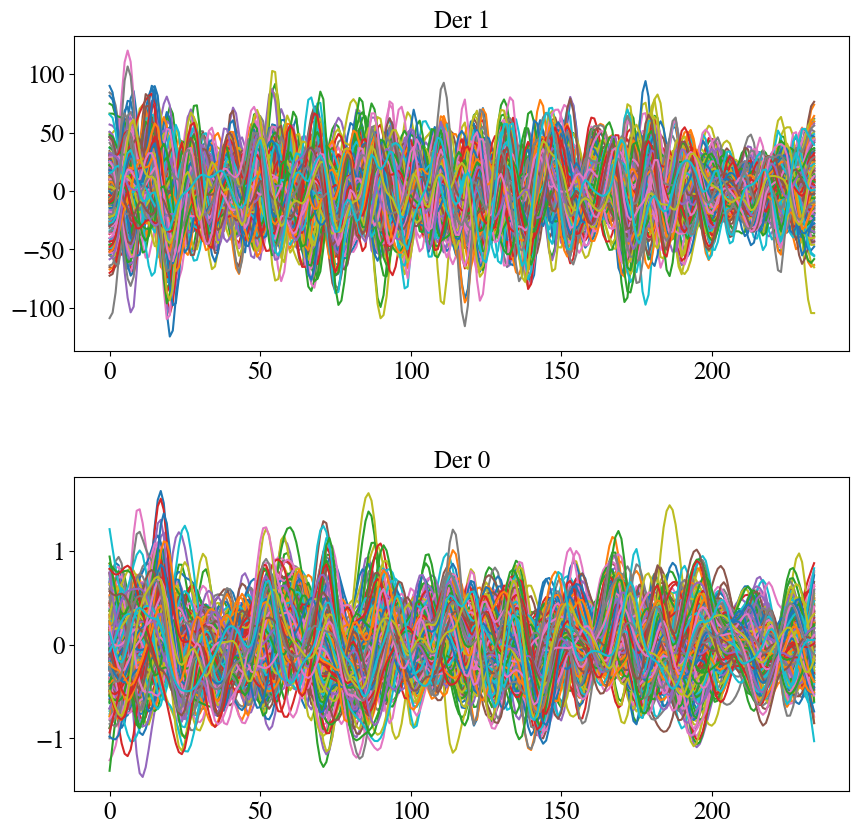

In [16]:
sub_ix = 0 
dXmat = dXmats[sub_ix]
Xmat = Xmats[sub_ix];

plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Der 1")
for roi_ix in range(num_rois):
    plt.plot(dXmat[roi_ix])
plt.subplot(212)
plt.title("Der 0")
for roi_ix in range(num_rois):
    plt.plot(Xmat[roi_ix])

## Detection

###  Reduce the dim of data

In [17]:
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
nXmats = eigvecs[:, :paras.r].T @ dXXmats["Xmats"]
ndXmats = eigvecs[:, :paras.r].T @ dXXmats["dXmats"];

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/dXXmats.pkl


### Estimate lam(t)

In [18]:
def get_gam_est(sY, sX, basis, ridge_pen=0):
    """Get gam est based on sY sX and basis
    args:
        sY (array): T vec
        sX (array): T vec
        basis (array): T x N matrix, the bspline basis
    we aim to find a gam vec with N x 1 such that np.mean((sY-basis@gam_est .* sX)**2) is minimal
    return: 
        gam_est (array): N vec
    """
    
    rvec = ((sY * sX)[:, None] * basis).sum(axis=0);
    wbasis = (sX[:, None] * basis);
    lmat = wbasis.T @ wbasis + ridge_pen*np.eye(wbasis.shape[1]);
    gam_est = np.linalg.pinv(lmat) @ rvec;
    return gam_est

In [19]:
def get_gam_est_mul(Y, X, basis, ridge_pen=0):
    """Get gam est based on Y X and basis
    args:
        sY (array): dxT mat
        sX (array): dxT mat
        basis (array): T x N matrix, the bspline basis
    return: 
        gam_ests (array): d x N mat 
    """
    
    d = Y.shape[0]
    gam_ests = []
    for d_ix in range(d):
        sY = Y[d_ix]
        sX = X[d_ix]
        gam_est = get_gam_est(sY, sX, basis, ridge_pen=ridge_pen)
        gam_ests.append(gam_est)
    return np.array(gam_ests)

In [20]:
def _run_fn(sub_ix):
    gam_ests = get_gam_est_mul(ndXmats[sub_ix], nXmats[sub_ix], basis, 0.0);
    lam_ests = basis @ gam_ests.T;
    return lam_ests
with Parallel(n_jobs=20) as parallel:
    cpts = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(nXmats.shape[0]), total=nXmats.shape[0]))
    
save_pkl(save_dir/"lam_ests.pkl", cpts, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1342.26it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/lam_ests.pkl


Text(0, 0.5, 'Lam(t)')

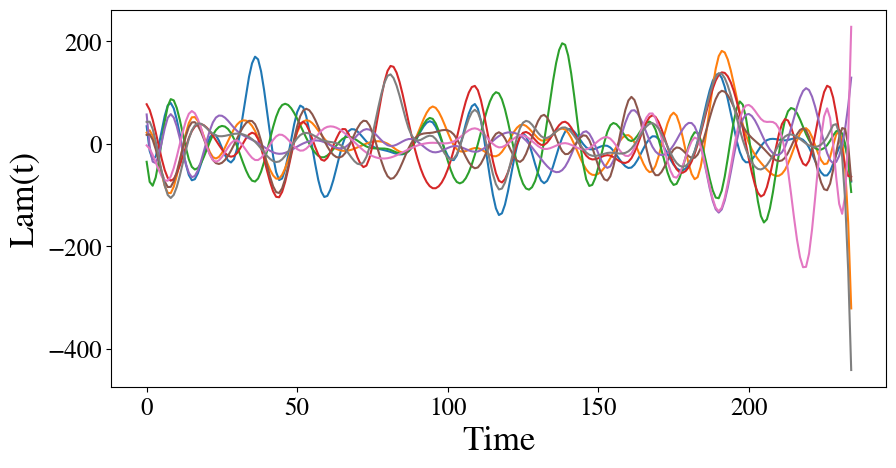

In [21]:
lam_est = cpts[1]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

# Analysis

In [22]:
def _get_dftb(metric):
    res_df = pd.DataFrame({
        "metric": metric,
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    return res_df

In [23]:

save_dir = RES_ROOT/"congTVDN2grp_projsc_unctest/"
paras = load_pkl(save_dir/"paras.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/paras.pkl


In [24]:
lam_ests = load_pkl(save_dir/"lam_ests.pkl");
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
nXmats = eigvecs[:, :paras.r].T @ dXXmats["Xmats"]
ndXmats = eigvecs[:, :paras.r].T @ dXXmats["dXmats"];

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/lam_ests.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_unctest/dXXmats.pkl


In [25]:
len(lam_ests)

182

Text(0, 0.5, 'Lam(t)')

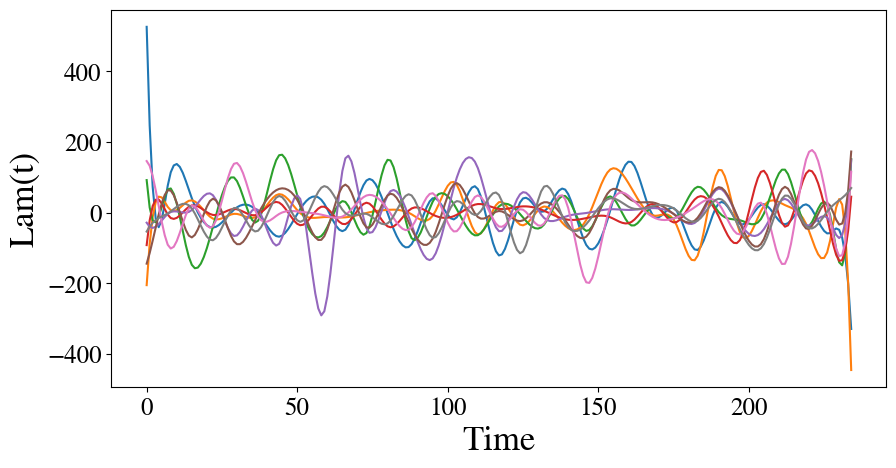

In [26]:
lam_est = lam_ests[0]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

## Correlation

In [27]:
corr_fs = []
for lam_est in lam_ests:
    mat = np.corrcoef(lam_est.T);
    idxs = np.triu_indices_from(mat, k=1)
    corr_fs.append(np.max(np.abs(mat[idxs])))

In [28]:
res_df = pd.DataFrame({
    "metric": corr_fs, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.474,0.107
(non-param) AD vs HC,0.465,0.107


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.64195,0.081685,0.473341,0.586060,0.633181,0.698659,0.869074
HC,100.0,0.63359,0.075357,0.483790,0.582668,0.622658,0.671518,0.824426


## cpts

In [29]:
def get_cpts(lam_est):
    """Get cpts based on lam est
    args:
        lam_est (array): T x r mat
    return:
        cpts_raw: the cpts and corresponding Uix (from 0)
    """
    raw_segs = np.argmax(np.abs(lam_est), axis=1);
    # i is a cpt if changes start at i
    # index is from 0
    cpts_raw = np.where(np.diff(raw_segs)!=0)[0]+1
    cpts_raw_full = np.concatenate([[0], cpts_raw, [lam_est.shape[0]]])
    return cpts_raw_full, raw_segs[cpts_raw_full[:-1]]

In [30]:
Lmin = 5 
ncpt_fn = lambda cpts: np.sum(np.diff(cpts) > Lmin)-1
ncpt_fn = lambda cpts: len(cpts)-2

cptss = []
Uidxs = []
for lam_est in lam_ests:
    cptss.append(get_cpts(lam_est)[0])
    Uidxs.append(get_cpts(lam_est)[1])
ncpts = np.array([ncpt_fn(cpts) for cpts in cptss]);

In [31]:
res_df = _get_dftb(ncpts)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.305,0.153
(non-param) AD vs HC,0.340,0.153


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,62.487805,4.977093,50.0,59.0,62.0,66.0,75.0
HC,100.0,61.790000,4.183409,51.0,59.0,62.0,64.0,70.0


## Dwell time

In [32]:
dwells =[np.diff(cpts) for cpts in cptss];
max_dwells = np.array([np.max(dwell) for dwell in dwells]);
mean_dwells = np.array([np.mean(dwell) for dwell in dwells]);

In [33]:
# get the dwell time for each U
dwells_perU = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perU[sub_ix, u_ix] = np.sum(dwell[Uidx==u_ix])
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = _get_dftb(dwells_perU[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
*AD vs HC,0.039,0.306
(non-param) *AD vs HC,0.024,0.306


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.146341,7.922654,1.0,7.00,12.5,18.00,42.0
HC,100.0,10.720000,7.786391,0.0,5.75,10.0,14.25,38.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.220,0.183
(non-param) AD vs HC,0.332,0.183


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.804878,9.054620,0.0,6.25,12.0,18.75,49.0
HC,100.0,11.270000,7.764013,0.0,5.00,10.0,18.00,32.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.827,0.033
(non-param) AD vs HC,0.666,0.033


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.195122,8.165630,0.0,5.00,10.5,15.0,37.0
HC,100.0,10.920000,8.690736,0.0,4.75,9.0,16.0,38.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.489,0.103
(non-param) AD vs HC,0.423,0.103


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.036585,7.397773,0.0,6.25,12.0,17.00,30.0
HC,100.0,11.250000,7.794553,0.0,5.00,10.0,16.25,35.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.366,0.135
(non-param) AD vs HC,0.305,0.135


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.012195,8.185344,0.0,7.0,12.0,17.0,35.0
HC,100.0,11.890000,8.419428,0.0,6.0,11.0,16.0,43.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.083,-0.257
(non-param) AD vs HC,0.221,-0.257


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.146341,7.113059,0.0,6.0,11.0,15.75,28.0
HC,100.0,13.330000,9.357172,0.0,7.0,11.5,18.00,44.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.866,0.025
(non-param) AD vs HC,0.948,0.025


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.04878,9.023840,0.0,6.0,11.0,15.75,41.0
HC,100.0,11.84000,7.660366,0.0,6.0,11.0,15.25,31.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.745,-0.049
(non-param) AD vs HC,0.814,-0.049


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.45122,7.856982,0.0,5.0,10.5,17.0,35.0
HC,100.0,11.84000,8.112492,0.0,6.0,10.5,17.0,34.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.217,0.184
(non-param) AD vs HC,0.211,0.184


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.02439,8.473598,0.0,7.0,13.0,18.5,39.0
HC,100.0,11.56000,7.463473,0.0,6.0,11.0,16.0,46.0


lam ix is 9:


Test,Pval,Effect size
*AD vs HC,0.025,-0.332
(non-param) *AD vs HC,0.042,-0.332


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,9.512195,7.267795,0.0,4.0,8.0,13.75,31.0
HC,100.0,12.350000,9.252218,0.0,6.0,12.0,17.00,49.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.198,-0.192
(non-param) AD vs HC,0.242,-0.192


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.512195,8.696876,0.0,6.25,12.0,18.0,41.0
HC,100.0,14.240000,9.181800,0.0,7.00,13.0,20.0,36.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.192,-0.194
(non-param) AD vs HC,0.101,-0.194


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.792683,9.026351,0.0,4.0,10.0,15.00,40.0
HC,100.0,12.500000,8.507276,0.0,6.0,12.5,17.25,55.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.893,-0.020
(non-param) AD vs HC,0.973,-0.020


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.50,7.206393,0.0,5.00,9.0,14.75,29.0
HC,100.0,10.65,7.737323,0.0,4.75,9.0,16.00,30.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.775,-0.043
(non-param) AD vs HC,0.588,-0.043


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.04878,7.766504,0.0,4.00,9.5,13.0,37.0
HC,100.0,10.37000,7.364472,0.0,4.75,10.0,15.0,34.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.066,-0.273
(non-param) AD vs HC,0.061,-0.273


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.853659,7.768442,0.0,5.00,10.0,15.00,29.0
HC,100.0,13.030000,8.005623,0.0,6.75,13.0,18.25,40.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.098,0.246
(non-param) AD vs HC,0.103,0.246


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.890244,9.468605,0.0,5.25,12.0,18.0,36.0
HC,100.0,10.640000,8.755397,0.0,4.00,9.0,16.0,46.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.527,0.094
(non-param) AD vs HC,0.726,0.094


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.829268,9.366087,0.0,6.00,11.0,17.0,42.0
HC,100.0,12.000000,8.270674,0.0,5.75,10.5,17.0,39.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.418,0.121
(non-param) AD vs HC,0.510,0.121


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.158537,8.401160,0.0,5.0,11.5,18.0,36.0
HC,100.0,11.200000,7.519671,0.0,6.0,10.0,15.0,35.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.852,0.028
(non-param) AD vs HC,0.787,0.028


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.402439,7.826608,0.0,6.00,10.0,16.0,32.0
HC,100.0,11.180000,8.141898,0.0,4.75,11.0,16.0,35.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.627,-0.072
(non-param) AD vs HC,0.439,-0.072


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.634146,8.499110,0.0,5.0,10.5,15.00,34.0
HC,100.0,12.220000,7.712747,0.0,6.0,11.0,17.25,32.0


In [34]:
# get the dwell time for each U
dwells_perUm = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUm[sub_ix, u_ix] = np.mean(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = pd.DataFrame({
        "metric": dwells_perUm[:, u_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.057,0.282
(non-param) *AD vs HC,0.031,0.282


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.852178,1.547105,1.0,3.0,3.775000,4.666667,9.0
HC,100.0,3.355524,1.885022,0.0,2.5,3.291667,4.212500,11.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.292,0.157
(non-param) AD vs HC,0.426,0.157


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.650143,1.793852,0.0,2.333333,3.619048,4.666667,9.0
HC,100.0,3.379500,1.652285,0.0,2.458333,3.500000,4.500000,7.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.468,0.108
(non-param) AD vs HC,0.495,0.108


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.520325,1.847599,0.0,2.375,3.416667,4.666667,9.5
HC,100.0,3.312643,1.972839,0.0,2.000,3.000000,4.541667,10.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.857,-0.027
(non-param) AD vs HC,0.977,-0.027


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.381799,1.586586,0.0,2.333333,3.291667,4.50000,8.5
HC,100.0,3.430929,2.003421,0.0,2.107143,3.450000,4.43125,10.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.478,0.106
(non-param) AD vs HC,0.465,0.106


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.781127,1.702958,0.0,2.425000,3.732143,5.000000,7.5
HC,100.0,3.596063,1.781298,0.0,2.383333,3.550000,4.756944,9.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.899,0.019
(non-param) AD vs HC,0.544,0.019


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.500755,2.023902,0.0,2.000000,3.2500,4.575,10.0
HC,100.0,3.467127,1.531024,0.0,2.666667,3.6125,4.400,7.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.915,0.016
(non-param) AD vs HC,0.764,0.016


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.548355,2.022760,0.0,2.333333,3.500000,4.575,10.500000
HC,100.0,3.519750,1.581615,0.0,2.229167,3.666667,4.525,7.333333


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.778,-0.042
(non-param) AD vs HC,0.871,-0.042


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.458808,1.836607,0.0,2.25,3.550000,4.575,9.0
HC,100.0,3.541516,2.062600,0.0,2.50,3.333333,4.500,10.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.905,-0.018
(non-param) AD vs HC,0.664,-0.018


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.647488,1.687597,0.0,2.75,3.812500,4.958333,6.666667
HC,100.0,3.677488,1.692991,0.0,2.50,3.633333,5.000000,10.000000


lam ix is 9:


Test,Pval,Effect size
*AD vs HC,0.043,-0.301
(non-param) *AD vs HC,0.041,-0.301


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.036672,1.633644,0.0,2.0,3.0,4.000,8.0
HC,100.0,3.581702,1.909509,0.0,2.5,3.5,4.525,11.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.372,-0.133
(non-param) AD vs HC,0.258,-0.133


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.419120,1.990672,0.0,2.270833,3.333333,4.458333,10.0
HC,100.0,3.651325,1.506098,0.0,3.000000,3.708333,4.500000,7.0


lam ix is 11:


Test,Pval,Effect size
*AD vs HC,0.006,-0.402
(non-param) *AD vs HC,0.007,-0.402


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.155801,1.919035,0.0,2.00000,3.0625,4.2,9.0
HC,100.0,3.957202,1.979871,0.0,2.85119,4.0000,5.0,9.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.133,0.224
(non-param) AD vs HC,0.269,0.224


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.708885,1.901411,0.0,2.425000,3.500000,4.958333,9.0
HC,100.0,3.300155,1.742722,0.0,2.482143,3.133929,4.333333,8.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.268,-0.165
(non-param) AD vs HC,0.098,-0.165


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.213386,1.847458,0.0,2.000000,3.000000,4.000000,11.0
HC,100.0,3.521190,1.867122,0.0,2.333333,3.583333,4.541667,12.0


lam ix is 14:


Test,Pval,Effect size
*AD vs HC,0.027,-0.328
(non-param) AD vs HC,0.062,-0.328


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.355691,1.806289,0.0,2.0,3.416667,4.8125,8.0
HC,100.0,4.000524,2.041305,0.0,2.8,3.775000,5.3500,11.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.539,-0.092
(non-param) AD vs HC,0.474,-0.092


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.189707,1.717454,0.0,2.0,3.500000,4.3125,8.0
HC,100.0,3.355694,1.880337,0.0,2.0,3.645833,4.5000,8.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.672,-0.063
(non-param) AD vs HC,0.845,-0.063


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.495930,1.900791,0.0,2.071429,3.666667,4.592857,11.0
HC,100.0,3.622095,2.072141,0.0,2.000000,3.500000,4.762500,10.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.917,0.016
(non-param) AD vs HC,0.826,0.016


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.636702,1.706016,0.0,2.525,3.732143,4.7500,8.0
HC,100.0,3.609583,1.764371,0.0,2.625,3.500000,4.8125,8.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.952,-0.009
(non-param) AD vs HC,0.685,-0.009


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.358479,1.749196,0.0,2.400000,3.154762,4.500000,9.0
HC,100.0,3.374250,1.788143,0.0,2.333333,3.464286,4.595238,8.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.881,-0.022
(non-param) AD vs HC,0.875,-0.022


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.462103,1.731246,0.0,2.270833,3.666667,4.421429,9.0
HC,100.0,3.501440,1.782548,0.0,2.333333,3.366667,4.500000,9.0


In [35]:
# get the dwell time for each U
dwells_perUmax = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUmax[sub_ix, u_ix] = np.max(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = pd.DataFrame({
        "metric": dwells_perUmax[:, u_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
*AD vs HC,0.010,0.379
(non-param) *AD vs HC,0.005,0.379


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.207317,2.512870,1.0,5.00,7.0,8.0,11.0
HC,100.0,5.150000,2.907236,0.0,3.75,5.0,7.0,13.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.535,0.093
(non-param) AD vs HC,0.599,0.093


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.646341,2.705148,0.0,4.0,6.0,7.75,12.0
HC,100.0,5.390000,2.817317,0.0,3.0,6.0,8.00,10.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.349,0.140
(non-param) AD vs HC,0.354,0.140


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.353659,2.911755,0.0,3.0,6.0,7.0,11.0
HC,100.0,4.940000,2.990963,0.0,3.0,5.0,7.0,12.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.937,-0.012
(non-param) AD vs HC,0.938,-0.012


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.207317,2.537316,0.0,3.0,6.0,7.0,10.0
HC,100.0,5.240000,2.961436,0.0,3.0,5.0,7.0,13.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.326,0.146
(non-param) AD vs HC,0.313,0.146


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.060976,2.763731,0.0,4.0,7.0,8.0,11.0
HC,100.0,5.640000,2.952554,0.0,4.0,6.0,8.0,12.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.361,-0.136
(non-param) AD vs HC,0.403,-0.136


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.268293,2.789083,0.0,3.0,6.0,7.0,10.0
HC,100.0,5.630000,2.529243,0.0,4.0,6.0,7.0,10.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.758,-0.046
(non-param) AD vs HC,0.866,-0.046


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.536585,2.986369,0.0,3.0,6.0,8.0,12.0
HC,100.0,5.670000,2.835757,0.0,4.0,6.0,8.0,13.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.944,0.010
(non-param) AD vs HC,0.941,0.010


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.560976,3.035175,0.0,3.0,6.0,8.0,11.0
HC,100.0,5.530000,2.921377,0.0,3.0,6.0,8.0,11.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.694,0.059
(non-param) AD vs HC,0.620,0.059


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.804878,2.991507,0.0,4.00,6.0,8.0,12.0
HC,100.0,5.640000,2.653452,0.0,3.75,6.0,8.0,12.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.070,-0.269
(non-param) AD vs HC,0.069,-0.269


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.743902,2.78803,0.0,3.0,5.0,7.0,11.0
HC,100.0,5.520000,2.91454,0.0,3.0,6.0,8.0,11.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.255,-0.170
(non-param) AD vs HC,0.444,-0.170


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.439024,2.952704,0.0,4.00,6.0,7.75,13.0
HC,100.0,5.910000,2.605724,0.0,4.75,6.0,7.00,14.0


lam ix is 11:


Test,Pval,Effect size
*AD vs HC,0.013,-0.366
(non-param) *AD vs HC,0.009,-0.366


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.841463,3.065014,0.0,3.0,5.0,7.0,11.0
HC,100.0,5.910000,2.693408,0.0,4.0,6.5,8.0,12.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.917,0.016
(non-param) AD vs HC,0.924,0.016


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.292683,2.705677,0.0,3.0,5.0,7.0,12.0
HC,100.0,5.250000,2.768419,0.0,3.0,6.0,7.0,11.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.349,-0.140
(non-param) AD vs HC,0.272,-0.140


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.926829,2.980515,0.0,3.0,5.0,7.0,15.0
HC,100.0,5.340000,2.930922,0.0,3.0,5.0,8.0,12.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.068,-0.271
(non-param) AD vs HC,0.085,-0.271


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.292683,2.899501,0.0,4.0,6.0,7.0,11.0
HC,100.0,6.070000,2.800631,0.0,4.0,6.0,8.0,13.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.516,0.097
(non-param) AD vs HC,0.378,0.097


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.317073,2.972624,0.0,3.0,6.0,8.0,10.0
HC,100.0,5.030000,2.945481,0.0,3.0,5.0,7.0,12.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.634,-0.071
(non-param) AD vs HC,0.594,-0.071


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.487805,2.851224,0.0,4.00,6.0,7.0,11.0
HC,100.0,5.700000,3.086301,0.0,3.75,6.0,8.0,12.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.976,-0.005
(non-param) AD vs HC,0.924,-0.005


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.487805,2.663164,0.0,3.25,6.0,7.0,11.0
HC,100.0,5.500000,2.691175,0.0,4.00,6.0,8.0,10.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.746,0.048
(non-param) AD vs HC,0.974,0.048


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.243902,2.742266,0.0,4.0,5.0,7.0,11.0
HC,100.0,5.110000,2.784862,0.0,3.0,5.5,7.0,11.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.695,-0.058
(non-param) AD vs HC,0.737,-0.058


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.353659,2.860424,0.0,3.25,6.0,7.0,11.0
HC,100.0,5.520000,2.833708,0.0,3.00,6.0,7.0,13.0


In [36]:
res_df = pd.DataFrame({
    "metric": max_dwells, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.748,-0.048
(non-param) AD vs HC,0.862,-0.048


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.219512,1.133381,8.0,9.0,10.0,11.0,15.0
HC,100.0,10.280000,1.356466,8.0,9.0,10.0,11.0,14.0


In [38]:
res_df = pd.DataFrame({
    "metric": mean_dwells, 
    "sex": sex_labs_sub, 
    "diagnosis": diag_labs_sub
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.403,-0.125
(non-param) AD vs HC,0.340,-0.125


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.724783,0.302588,3.092105,3.507463,3.730159,3.916667,4.607843
HC,100.0,3.759525,0.256901,3.309859,3.615385,3.730159,3.916667,4.519231


## Mean lam(t) over time 

In [39]:
lam_ests_mean = np.array([np.mean(lam_est, axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    #display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.850,-0.028
(non-param) AD vs HC,0.940,-0.028


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.967,-0.006
(non-param) AD vs HC,0.575,-0.006


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.107,0.239
(non-param) *AD vs HC,0.038,0.239


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.179,0.200
(non-param) AD vs HC,0.426,0.200


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.329,-0.145
(non-param) AD vs HC,0.421,-0.145


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.682,-0.061
(non-param) AD vs HC,0.559,-0.061


lam ix is 6:


Test,Pval,Effect size
*AD vs HC,0.023,0.337
(non-param) AD vs HC,0.055,0.337


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.819,0.034
(non-param) AD vs HC,0.496,0.034


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.293,-0.157
(non-param) AD vs HC,0.287,-0.157


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.182,-0.199
(non-param) AD vs HC,0.111,-0.199


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.692,0.059
(non-param) AD vs HC,0.911,0.059


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.914,-0.016
(non-param) AD vs HC,0.827,-0.016


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.438,-0.116
(non-param) AD vs HC,0.511,-0.116


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.622,-0.074
(non-param) AD vs HC,0.716,-0.074


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.669,0.064
(non-param) AD vs HC,0.904,0.064


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.642,-0.069
(non-param) AD vs HC,0.646,-0.069


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.779,-0.042
(non-param) AD vs HC,0.533,-0.042


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.266,0.165
(non-param) AD vs HC,0.297,0.165


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.978,0.004
(non-param) AD vs HC,0.535,0.004


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.568,-0.085
(non-param) AD vs HC,0.721,-0.085


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'HC'}>

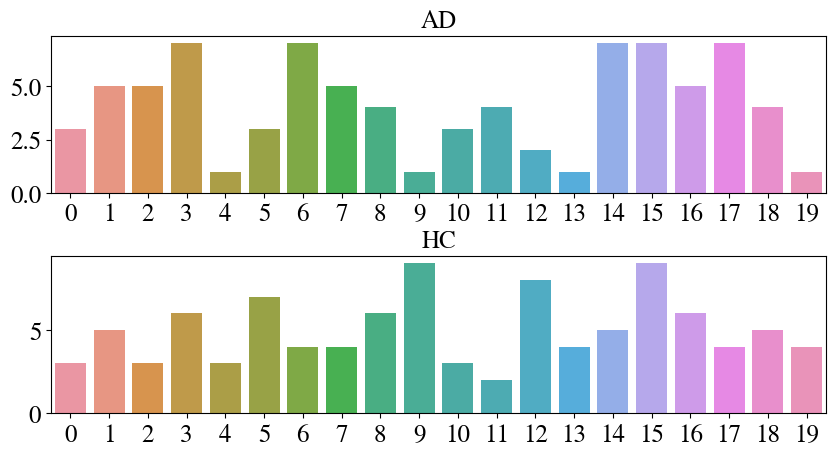

In [69]:
max_abs_idxs = np.argmax(lam_ests_mean, axis=1)
grp1 = np.unique(max_abs_idxs[diag_labs_sub==1], return_counts=True)
grp2 = np.unique(max_abs_idxs[diag_labs_sub==6], return_counts=True);

plt.figure(figsize=[10, 5])
plt.subplot(211)
plt.title(f"{diag_lab_mapping[1]}")
sns.barplot(grp1[0], grp1[1])
plt.subplot(212)
plt.title(f"{diag_lab_mapping[6]}")
sns.barplot(grp2[0], grp2[1])

Text(0, 0.5, 'mean(lam(t))')

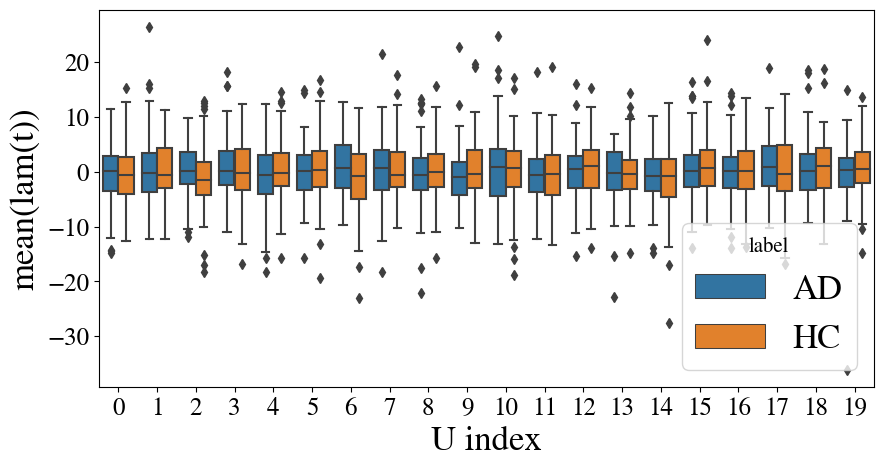

In [70]:

vs = []
labs = []
lamixs = []
for lam_ix in range(lam_ests_mean.shape[1]):
    cur_v = lam_ests_mean[:, lam_ix]
    cur_lb = diag_labs_sub
    cur_lamix = [lam_ix] * len(cur_v)
    vs.append(cur_v)
    labs.append(cur_lb)
    lamixs.append(cur_lamix)

df = pd.DataFrame({
    "v": np.concatenate(vs),
    "labs": np.concatenate(labs),
    "lamixs": np.concatenate(lamixs)
})
df["label"] = df["labs"].map(lambda x: diag_lab_mapping[x])
sns.boxplot(data=df, y="v", x="lamixs", hue="label")
plt.xlabel("U index")
plt.ylabel("mean(lam(t))")

In [40]:
lam_ests_mean_abs = np.array([np.mean(np.abs(lam_est), axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean_abs.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean_abs[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.365,0.135
(non-param) AD vs HC,0.405,0.135


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.427024,7.648836,25.507614,34.418089,37.973323,44.123943,60.650815
HC,100.0,38.444796,6.926363,24.791305,33.317138,37.550999,42.477340,58.977039


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.259,0.168
(non-param) AD vs HC,0.522,0.168


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.353196,8.829974,22.152893,33.072705,38.126402,45.132266,70.488846
HC,100.0,37.997382,7.309887,19.585478,33.124554,37.794150,42.304669,58.128051


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.901,0.019
(non-param) AD vs HC,0.656,0.019


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.389983,7.601907,21.111528,33.847232,38.024801,43.131482,55.483258
HC,100.0,38.240130,8.386994,22.942513,33.395371,37.300854,43.448987,71.358567


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.099,0.245
(non-param) *AD vs HC,0.029,0.245


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,40.315014,6.733785,21.110403,36.743374,39.937447,44.635360,53.659065
HC,100.0,38.445870,8.185502,22.077680,32.988199,37.087826,44.053837,59.444275


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.503,0.100
(non-param) AD vs HC,0.500,0.100


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.650418,7.911508,23.259477,34.178007,38.082602,44.486826,60.897808
HC,100.0,38.898627,7.179423,26.462663,33.111580,37.767895,44.009544,56.146462


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.288,-0.158
(non-param) AD vs HC,0.421,-0.158


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.429255,5.836129,23.593641,35.561175,39.018970,41.661812,52.636392
HC,100.0,39.595988,8.393106,24.185799,34.520471,38.975482,45.370687,65.893053


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.592,0.080
(non-param) AD vs HC,0.956,0.080


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,40.17373,9.052873,25.198799,34.111196,38.707590,44.338068,73.560169
HC,100.0,39.51489,7.490041,24.472613,34.269784,39.031686,44.603948,60.110644


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.749,-0.048
(non-param) AD vs HC,0.875,-0.048


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.512122,7.415663,17.201042,32.51621,39.070714,43.144218,60.474197
HC,100.0,38.858697,7.151142,22.424460,34.10488,38.206233,43.878598,61.578307


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.928,-0.013
(non-param) AD vs HC,0.988,-0.013


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.034693,7.942341,19.688380,33.634398,39.199908,43.586469,54.201768
HC,100.0,39.134397,6.978141,23.579499,33.868496,39.424526,43.182425,62.675131


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.062,-0.278
(non-param) AD vs HC,0.181,-0.278


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,36.766488,7.637958,16.331666,30.339380,37.370004,41.064706,54.713471
HC,100.0,39.030305,8.418014,24.733662,32.399174,38.104298,43.693860,66.586824


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.408,-0.123
(non-param) AD vs HC,0.405,-0.123


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.365104,7.895988,23.828450,33.547524,36.254285,43.097660,60.033670
HC,100.0,39.370682,8.344906,24.174737,33.829630,38.555238,43.727629,67.774795


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.302,-0.154
(non-param) AD vs HC,0.472,-0.154


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.567383,8.268318,21.996249,30.634674,38.971199,43.242685,56.122122
HC,100.0,38.842251,8.254813,23.361980,33.106134,38.244870,43.119951,66.267013


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.201,-0.190
(non-param) AD vs HC,0.182,-0.190


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.611265,6.844548,22.305034,32.889138,37.006216,41.199732,62.774477
HC,100.0,38.971094,7.317717,21.416045,33.251877,38.670141,43.226985,56.970355


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.717,-0.054
(non-param) AD vs HC,0.695,-0.054


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.885740,6.329796,26.535646,33.705106,37.171399,41.255085,58.788992
HC,100.0,38.267979,7.596724,20.697021,32.563348,38.103173,42.813583,66.758687


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.208,-0.187
(non-param) AD vs HC,0.410,-0.187


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.462100,6.793005,22.959079,32.499692,37.778134,41.173329,56.799691
HC,100.0,38.907507,8.328087,18.468816,33.204148,38.423621,43.473839,68.639127


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.244,0.174
(non-param) AD vs HC,0.150,0.174


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.921377,8.392104,17.850338,33.268072,37.604198,44.139681,56.178177
HC,100.0,37.535634,7.581972,25.753505,32.128408,35.728230,40.053769,62.172149


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.782,-0.041
(non-param) AD vs HC,0.889,-0.041


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.770388,7.630675,20.612451,32.987842,40.246523,44.076231,58.978080
HC,100.0,39.093895,8.023690,20.708971,33.790048,39.035404,44.641728,67.369046


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.476,0.106
(non-param) AD vs HC,0.567,0.106


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.422867,7.650488,17.749105,32.429593,38.361495,43.008734,61.376429
HC,100.0,37.655488,6.837632,23.452305,32.641808,37.430861,42.314400,61.801191


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.553,0.088
(non-param) AD vs HC,0.531,0.088


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.767947,7.316621,18.921647,31.664184,38.878375,43.399321,54.899329
HC,100.0,37.129558,7.132294,22.655408,32.344370,36.992935,41.371063,55.784511


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.413,-0.122
(non-param) AD vs HC,0.320,-0.122


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.688691,7.352148,23.195925,32.745597,36.918235,42.350476,60.999178
HC,100.0,38.553963,6.841106,18.968528,34.862263,38.718718,42.736218,55.248927


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'HC'}>

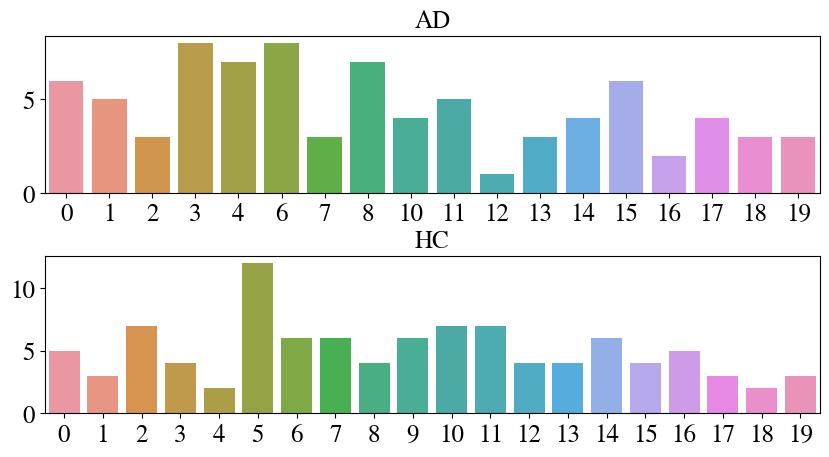

In [72]:
max_abs_idxs = np.argmax(lam_ests_mean_abs, axis=1)
grp1 = np.unique(max_abs_idxs[diag_labs_sub==1], return_counts=True)
grp2 = np.unique(max_abs_idxs[diag_labs_sub==6], return_counts=True);

plt.figure(figsize=[10, 5])
plt.subplot(211)
plt.title(f"{diag_lab_mapping[1]}")
sns.barplot(grp1[0], grp1[1])
plt.subplot(212)
plt.title(f"{diag_lab_mapping[6]}")
sns.barplot(grp2[0], grp2[1])

Text(0, 0.5, 'mean(lam(t))')

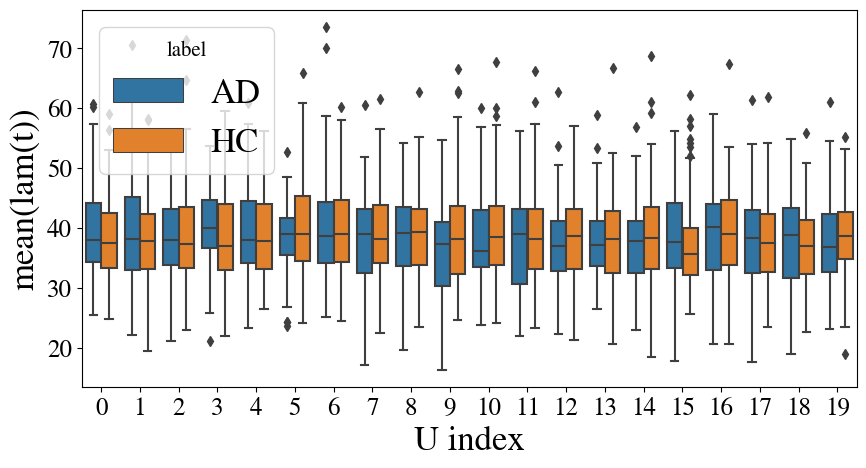

In [73]:

vs = []
labs = []
lamixs = []
for lam_ix in range(lam_ests_mean_abs.shape[1]):
    cur_v = lam_ests_mean_abs[:, lam_ix]
    cur_lb = diag_labs_sub
    cur_lamix = [lam_ix] * len(cur_v)
    vs.append(cur_v)
    labs.append(cur_lb)
    lamixs.append(cur_lamix)

df = pd.DataFrame({
    "v": np.concatenate(vs),
    "labs": np.concatenate(labs),
    "lamixs": np.concatenate(lamixs)
})
df["label"] = df["labs"].map(lambda x: diag_lab_mapping[x])
sns.boxplot(data=df, y="v", x="lamixs", hue="label")
plt.xlabel("U index")
plt.ylabel("mean(lam(t))")

In [74]:
def _fs_fn(lam_est, typ=1, is_abs=False):
    if is_abs:
        lam_est = np.abs(lam_est)
        
    if typ == 1:
        return np.mean(lam_est)
    elif typ == 2:
        return np.median(lam_est)
    elif typ == 3:
        return np.mean(lam_est, axis=0).max()
    elif typ == 4:
        return np.median(lam_est, axis=0).max()




for typ in [1, 2, 3, 4]:
    for is_abs in [True, False]:
        fs = np.array([_fs_fn(lam_est, typ=typ, is_abs=is_abs) for lam_est in lam_ests]);
        res_df = pd.DataFrame({
            "metric": fs,
            "sex": sex_labs_sub, 
            "diagnosis": diag_labs_sub
        })
        res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
        display(_get_test_tb(res_df))
        #display(res_df.groupby("diagnosis1")["metric"].describe())

Test,Pval,Effect size
AD vs HC,0.759,-0.046
(non-param) AD vs HC,0.555,-0.046


Test,Pval,Effect size
AD vs HC,0.851,0.028
(non-param) AD vs HC,0.844,0.028


Test,Pval,Effect size
AD vs HC,0.815,-0.035
(non-param) AD vs HC,0.511,-0.035


Test,Pval,Effect size
AD vs HC,0.491,0.103
(non-param) AD vs HC,0.449,0.103


Test,Pval,Effect size
AD vs HC,0.361,-0.136
(non-param) AD vs HC,0.575,-0.136


Test,Pval,Effect size
AD vs HC,0.307,0.152
(non-param) AD vs HC,0.507,0.152


Test,Pval,Effect size
AD vs HC,0.079,-0.261
(non-param) AD vs HC,0.133,-0.261


Test,Pval,Effect size
AD vs HC,0.392,-0.128
(non-param) AD vs HC,0.320,-0.128


## PSD of lam(t)

In [41]:
from scipy.signal import welch
def get_psd(ts, freq_lmts=[0.008, 0.08]):
    """
    Computes the power spectral density (PSD) of a given time series using Welch's method.
    
    Parameters:
    -----------
    ts : numpy.ndarray
        The time series data. Shape: (n_channels, n_samples).
    freq_lmts : list, optional
        The frequency limits (in Hz) to compute the PSD. Default: [0.008, 0.08].
    
    Returns:
    --------
    fs : numpy.ndarray
        The frequency values (in Hz) of the PSD. Shape: (n_freqs,).
    psds_dB_sm : numpy.ndarray
        The PSD values (in dB) of the time series data after smoothing. Shape: (n_channels, n_freqs).
    """
    lpf = np.array([1, 2, 5, 2, 1]) 
    lpf = lpf/np.sum(lpf)
    ac_time = 485
    fs, psds = welch(ts, fs=ts.shape[1]/ac_time, nperseg=int(ts.shape[1]/2))
    psds_dB = 10*np.log10(psds) # to dB
    psds_dB_sm = []
    for roi_ix in range(ts.shape[0]):
        cen = np.convolve(psds_dB[roi_ix],lpf,'valid')
        tmp = np.concatenate([psds_dB[roi_ix, :2], 
                              cen, 
                              psds_dB[roi_ix, -2:]])
        psds_dB_sm.append(tmp)
    psds_dB_sm = np.array(psds_dB_sm)
    kpidxs = np.bitwise_and(fs>=freq_lmts[0], fs<=freq_lmts[1])
    return fs[kpidxs], psds_dB_sm[:, kpidxs]
    

In [42]:
nsubj = len(lam_ests)
psds = []
for sub_ix in range(nsubj):
    freqs, psd = get_psd(lam_ests[sub_ix].T)
    psds.append(psd.T)
psds = np.array(psds);

In [43]:
mpsd_perfreq = psds.mean(axis=1);
nu = mpsd_perfreq.shape[-1]
for uidx in range(nu):
    res_df = _get_dftb(mpsd_perfreq[:, uidx])
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.721,0.053
(non-param) AD vs HC,0.820,0.053


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.320,0.148
(non-param) AD vs HC,0.408,0.148


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.411,0.122
(non-param) AD vs HC,0.375,0.122


lam ix is 3:


Test,Pval,Effect size
*AD vs HC,0.029,0.324
(non-param) *AD vs HC,0.038,0.324


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.324,0.147
(non-param) AD vs HC,0.360,0.147


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.850,-0.028
(non-param) AD vs HC,0.640,-0.028


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.933,-0.013
(non-param) AD vs HC,0.829,-0.013


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.484,0.104
(non-param) AD vs HC,0.272,0.104


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.893,0.020
(non-param) AD vs HC,0.945,0.020


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.120,-0.231
(non-param) AD vs HC,0.124,-0.231


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.724,0.053
(non-param) AD vs HC,0.878,0.053


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.187,-0.197
(non-param) AD vs HC,0.295,-0.197


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.712,-0.055
(non-param) AD vs HC,0.590,-0.055


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.787,-0.040
(non-param) AD vs HC,0.489,-0.040


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.453,-0.112
(non-param) AD vs HC,0.542,-0.112


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.522,0.095
(non-param) AD vs HC,0.305,0.095


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.580,-0.083
(non-param) AD vs HC,0.802,-0.083


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.711,0.055
(non-param) AD vs HC,0.902,0.055


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.987,-0.002
(non-param) AD vs HC,0.900,-0.002


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.865,0.025
(non-param) AD vs HC,0.731,0.025


In [44]:
maxpsd_perfreq = psds.max(axis=1);
nu = maxpsd_perfreq.shape[-1]
for uidx in range(nu):
    metric = maxpsd_perfreq[:, uidx]
    res_df = pd.DataFrame({
        "metric": metric,
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.853,0.028
(non-param) AD vs HC,0.781,0.028


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.617,0.075
(non-param) AD vs HC,0.548,0.075


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.952,0.009
(non-param) AD vs HC,0.936,0.009


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.350,0.139
(non-param) AD vs HC,0.177,0.139


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.324,0.147
(non-param) AD vs HC,0.624,0.147


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.596,0.079
(non-param) AD vs HC,0.755,0.079


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.725,-0.052
(non-param) AD vs HC,0.761,-0.052


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.698,0.058
(non-param) AD vs HC,0.522,0.058


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.584,0.082
(non-param) AD vs HC,0.522,0.082


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.066,-0.273
(non-param) AD vs HC,0.118,-0.273


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.332,-0.144
(non-param) AD vs HC,0.185,-0.144


lam ix is 11:


Test,Pval,Effect size
*AD vs HC,0.016,-0.355
(non-param) *AD vs HC,0.028,-0.355


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.948,-0.010
(non-param) AD vs HC,0.781,-0.010


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.678,-0.062
(non-param) AD vs HC,0.460,-0.062


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.228,-0.179
(non-param) AD vs HC,0.436,-0.179


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.208,0.187
(non-param) *AD vs HC,0.050,0.187


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.766,-0.044
(non-param) AD vs HC,0.929,-0.044


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.538,-0.092
(non-param) AD vs HC,0.495,-0.092


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.982,-0.003
(non-param) AD vs HC,0.909,-0.003


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.998,-0.000
(non-param) AD vs HC,0.740,-0.000


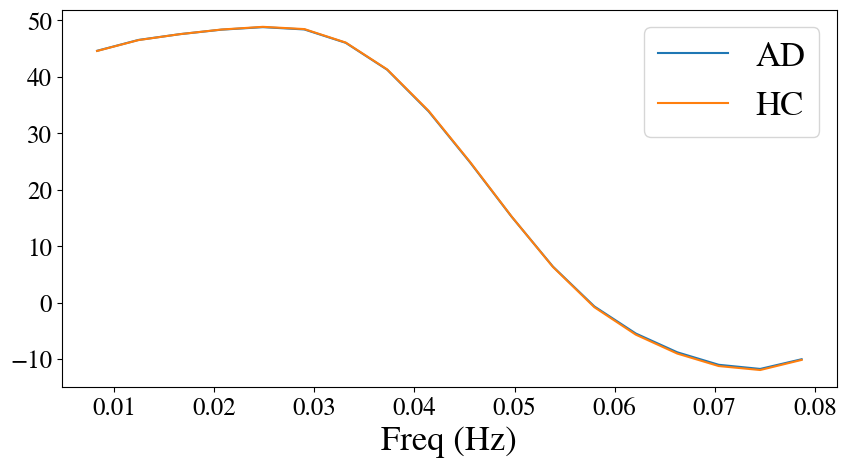

In [45]:
mpsd_perU = psds.mean(axis=2);
AD_psd = mpsd_perU[diag_labs_sub==1].mean(axis=0)
Ctrl_psd = mpsd_perU[diag_labs_sub==6].mean(axis=0)
plt.plot(freqs, AD_psd, label="AD")
plt.plot(freqs, Ctrl_psd, label="HC")
plt.xlabel("Freq (Hz)")
plt.legend()

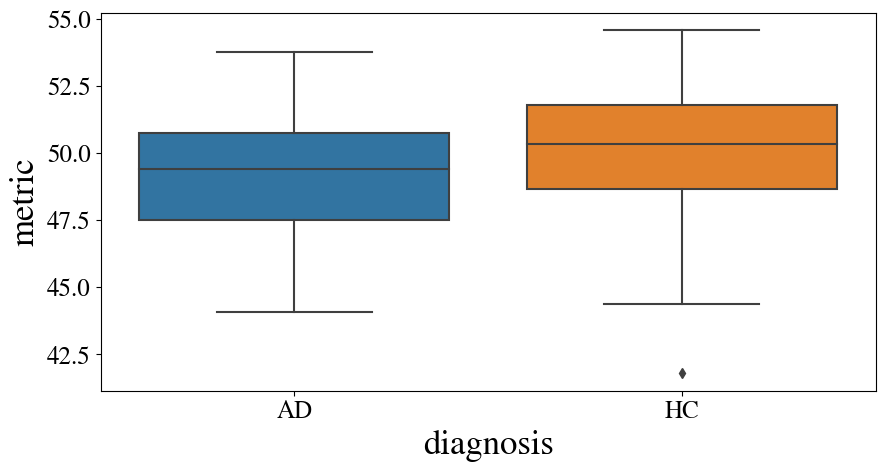

In [110]:
res_df = _get_dftb(maxpsd_perfreq[:, 6])

sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);